# Overall contribution

In [7]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
import pymc3 as pm
import arviz as az
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *


In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Germany', 'Austria',
       'France', 'Slovakia', 'Belgium', 'Italy', 'Portugal',#'Netherlands'
            ]
traces, models, dls = [], [], []
for country in tqdm(countries):
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(tune, draws, max_treedepth), " not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/11 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 4000 sample runs for Czechia
Use 4000 sample runs for Scotland
Use 4000 sample runs for Spain
Use 4000 sample runs for Germany
Use 4000 sample runs for Austria
Use 4000 sample runs for France
Use 4000 sample runs for Slovakia
Use 4000 sample runs for Belgium
Use 4000 sample runs for Italy
Use 4000 sample runs for Portugal


In [15]:
infections_no = []
infections_primary = []
infections_secondary = []
for i, country in enumerate(countries):
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}.pkl")
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(models[i].sim_begin, models[i].sim_end)
    y0 = get_from_trace("new_cases",trace_without_soccer,from_type="predictions")
    y1 = get_from_trace("new_cases",trace_primary_soccer,from_type="predictions") - y0
    y2 = get_from_trace("new_cases",traces[i]) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - models[i].sim_begin).days
    i_end = (end - models[i].sim_begin).days + 1  # inclusiv last day

    y0 = np.sum(y0[..., i_begin:i_end, :], axis=-2)
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=-2)
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=-2)

    infections_no.append(y0)
    infections_primary.append(y1)
    infections_secondary.append(y2)

In [16]:
data_primary  = pd.DataFrame()
means = []
for i,country in enumerate(countries):
    # compute fraction of infected people
    t_numpy = infections_primary[i] / (infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary = pd.concat([data_primary, temp])
    means.append(np.mean(temp["percentage_primary"]))
country_order_primar = np.argsort(means)[::-1]

data_primary_and_subsequent = pd.DataFrame()
means = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = (infections_primary[i]+infections_secondary[i])/(infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary_and_subsequent", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary_and_subsequent = pd.concat([data_primary_and_subsequent, temp])
    means.append(np.mean(temp["percentage_primary_and_subsequent"]))
country_order_primary_and_subsequent = np.argsort(means)[::-1]

# Compute interesting values as fraction and as incidence
primary_frac = []
for i, country in enumerate(countries):
    temp_male = data_primary[(data_primary["country"] == country) & (data_primary["gender"] == "male")].drop(columns=["country","gender"])
    temp_female = data_primary[(data_primary["country"] == country) & (data_primary["gender"] == "female")].drop(columns=["country","gender"])

    primary_frac.append(np.array([temp_male.to_numpy()[:,0], temp_female.to_numpy()[:,0]]))

In [17]:
#for l
def reduce_samples(curr_list):
    number_of_samples = 2000
    for i, array in enumerate(curr_list):
        array = array[...,np.random.choice(array.shape[-1], number_of_samples, replace = False)]
        curr_list[i] = array
    return np.array(curr_list)

primary_frac = reduce_samples(primary_frac)

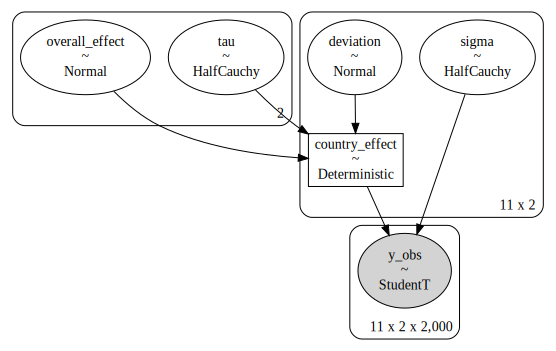

In [7]:
n_countries = len(countries)
with pm.Model() as model:
    overall_effect = pm.Normal("overall_effect", mu=0, sigma=10, shape=(2,))
    tau = pm.HalfCauchy("tau", beta=10, shape=(2,))

    deviation = pm.Normal("deviation", mu=0, sigma=1, shape=(n_countries, 2))
    country_effect = deviation*tau + overall_effect
    country_effect = pm.Deterministic("country_effect", country_effect)

    sigma_obs = pm.HalfCauchy("sigma", beta=10, shape=(n_countries, 2))

    pm.StudentT("y_obs", nu=4, mu=country_effect[...,None], sigma=sigma_obs[...,None], observed=primary_frac)

pm.model_to_graphviz(model)

In [8]:
with model:
    trace = pm.sample(tune=4000, draws=2000, chains=4, target_accept=0.95,
                      return_inferencedata=True)
    
    post_pred = pm.sample_posterior_predictive(trace)

az.concat(trace, az.from_pymc3(posterior_predictive=post_pred), inplace=True)

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_effect]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_effect]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 10035 seconds.
INFO     [pymc3] Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 10035 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, in

ERROR    [arviz.data.io_pymc3_3x] Got error No model on context stack. trying to find log_likelihood in translation.
/data.nst/smohr/anaconda3/envs/pymc3_new/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [9]:
pickle.dump(trace, open("/data.nst/smohr/covid19_soccer_data/trace_overall_effekt.pkl", "wb"))

## Check whether residuals are distributed like expected

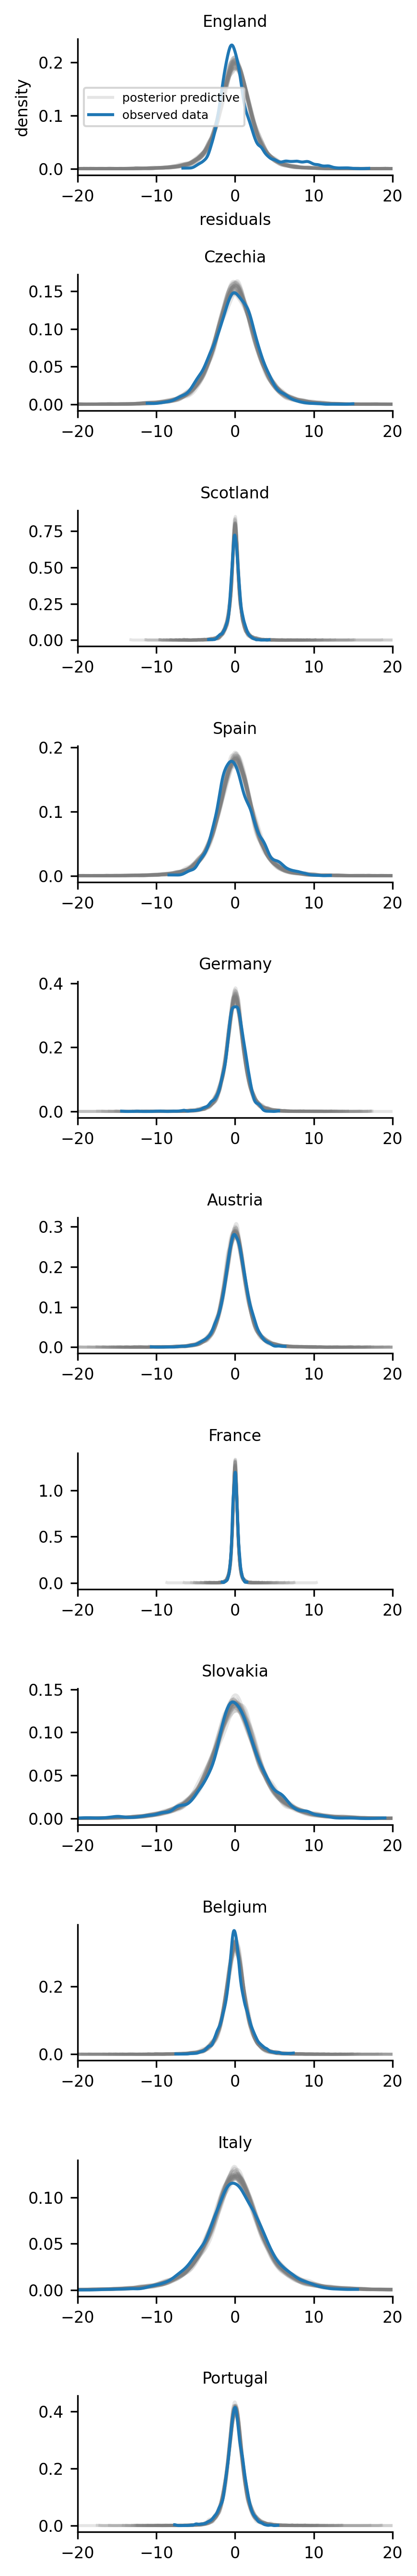

In [14]:
n_samples = 4000

# Calculate residuals
shape_resid = trace.posterior_predictive['y_obs'].shape[1:]
residuals_ppd = np.array(trace.posterior_predictive['y_obs']).reshape(shape_resid) - \
                np.array(trace.posterior['country_effect']).reshape(list(shape_resid[:-1]) + [1])
# (the arrays have to be reshaped, such that the resulting dim is (samples, n_countries)) 

residuals_obs = np.array(trace.observed_data['y_obs']) - \
                np.median(trace.posterior['country_effect'], axis=(0,1))[...,None]

# Plot:
fig, axes = plt.subplots(len(countries),1, figsize=(3,18))
for i, country in enumerate(countries):
    ax = axes[i]
    for j in range(30):
        az.plot_dist(residuals_ppd[np.random.choice(n_samples, 1), i].T, ax = ax, color="tab:gray", label="posterior predictive" if i == 0 and j==0 else None,
                    plot_kwargs=dict(alpha=0.2))
    az.plot_dist(residuals_obs[i], ax = ax, color="tab:blue", label="observed data" if i == 0 else None)
    if i ==0:
        ax.legend()
        ax.set_xlabel("residuals")
        ax.set_ylabel("density");
    ax.set_xlim(-20, 20)
    ax.set_title(country)
plt.tight_layout()
plt.show()
                                                            

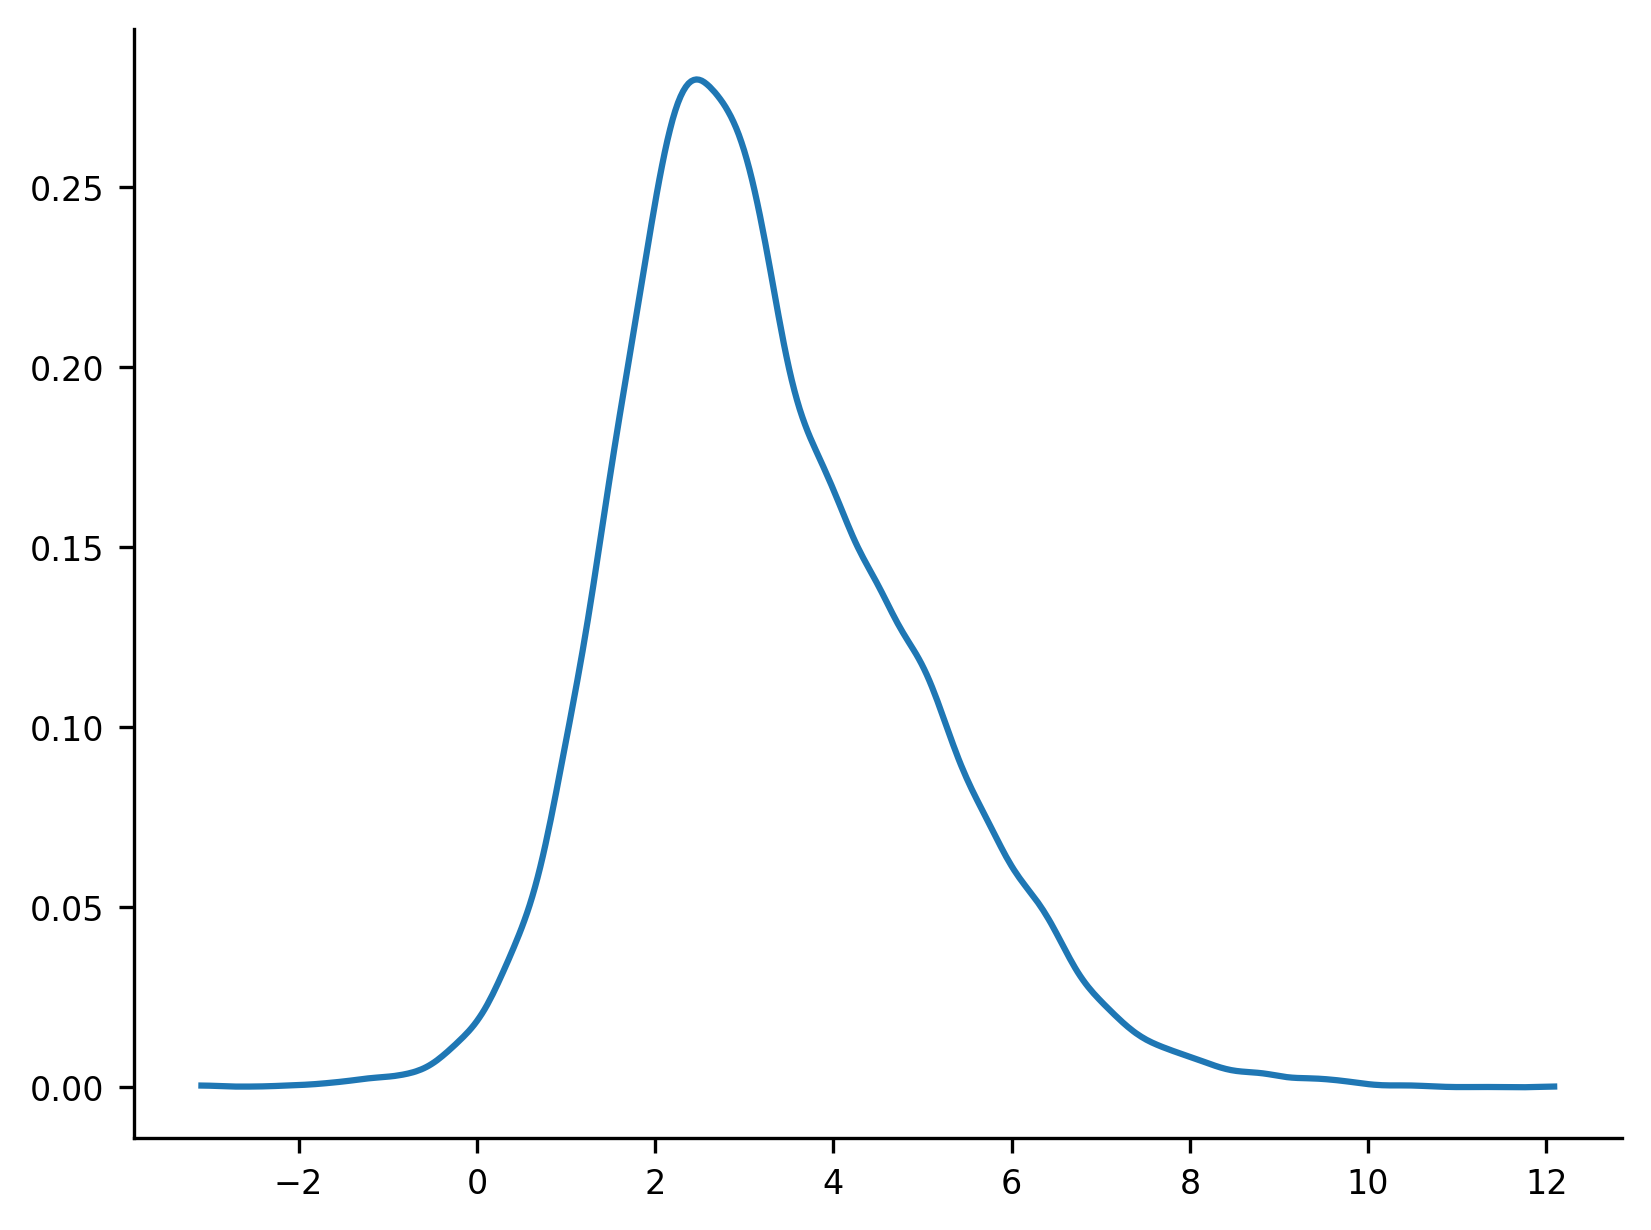

In [15]:
az.plot_dist(trace.posterior['overall_effect'])
plt.show()

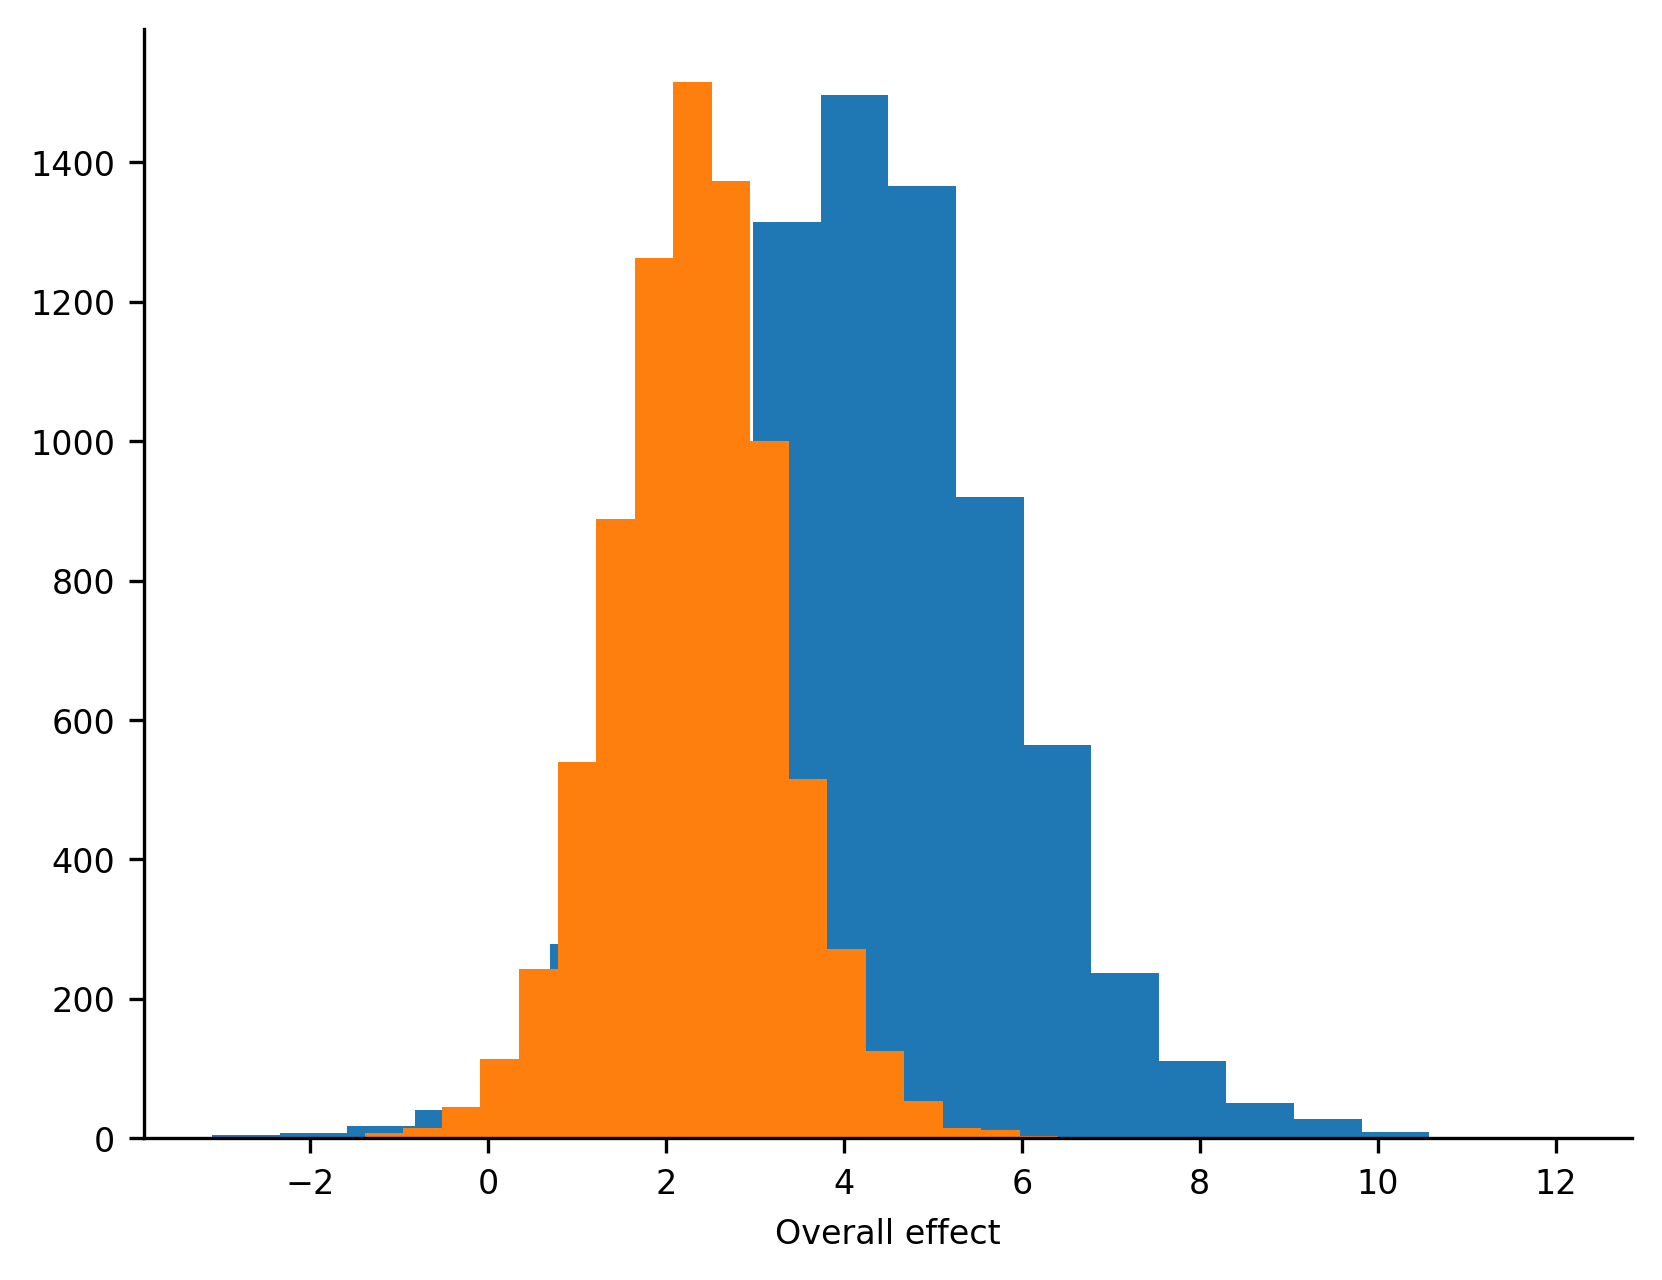

In [16]:
plt.hist(np.array(trace.posterior['overall_effect'][...,0]).flatten(), bins=20)
plt.hist(np.array(trace.posterior['overall_effect'][...,1]).flatten(), bins=20)
plt.xlabel("Overall effect")
plt.show()

## Sample alpha_mean overall

In [23]:
# Get alpha mean for each trace
alpha_mean=[]
for i, country in enumerate(countries):
    alpha_mean.append(get_from_trace("alpha_mean",traces[i]))
alpha_mean = reduce_samples(alpha_mean)

In [24]:
alpha_mean.shape

(11, 2000)

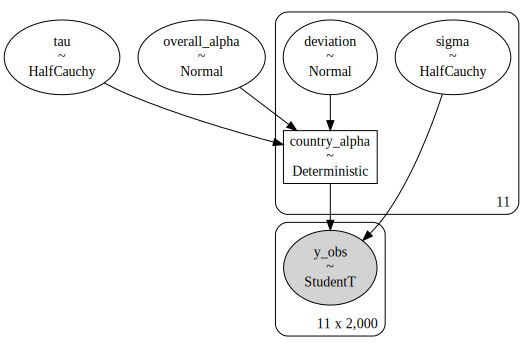

In [31]:



n_countries = len(countries)
with pm.Model() as model_alpha:
    overall_effect = pm.Normal("overall_alpha", mu=0, sigma=10,)
    tau = pm.HalfCauchy("tau", beta=10,)

    deviation = pm.Normal("deviation", mu=0, sigma=5, shape=(n_countries))
    country_effect = deviation*tau + overall_effect
    country_effect = pm.Deterministic("country_alpha", country_effect)

    sigma_obs = pm.HalfCauchy("sigma", beta=10, shape=(n_countries))

    pm.StudentT("y_obs", nu=4, mu=country_effect[...,None], sigma=sigma_obs[...,None], observed=alpha_mean)

pm.model_to_graphviz(model)

In [32]:
with model_alpha:
    trace_alpha = pm.sample(tune=4000, draws=2000, chains=4, target_accept=0.95,
                      return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, tau, overall_alpha]
INFO     [pymc3] NUTS: [sigma, deviation, tau, overall_alpha]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 1477 seconds.
INFO     [pymc3] Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 1477 seconds.
The number of effective samples is smaller than 25% for some parameters.
INFO     [pymc3] The number of effective samples is smaller than 25% for some parameters.


In [38]:
pickle.dump(trace_alpha, open("/data.nst/smohr/covid19_soccer_data/trace_overall_alpha.pkl", "wb"))

WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


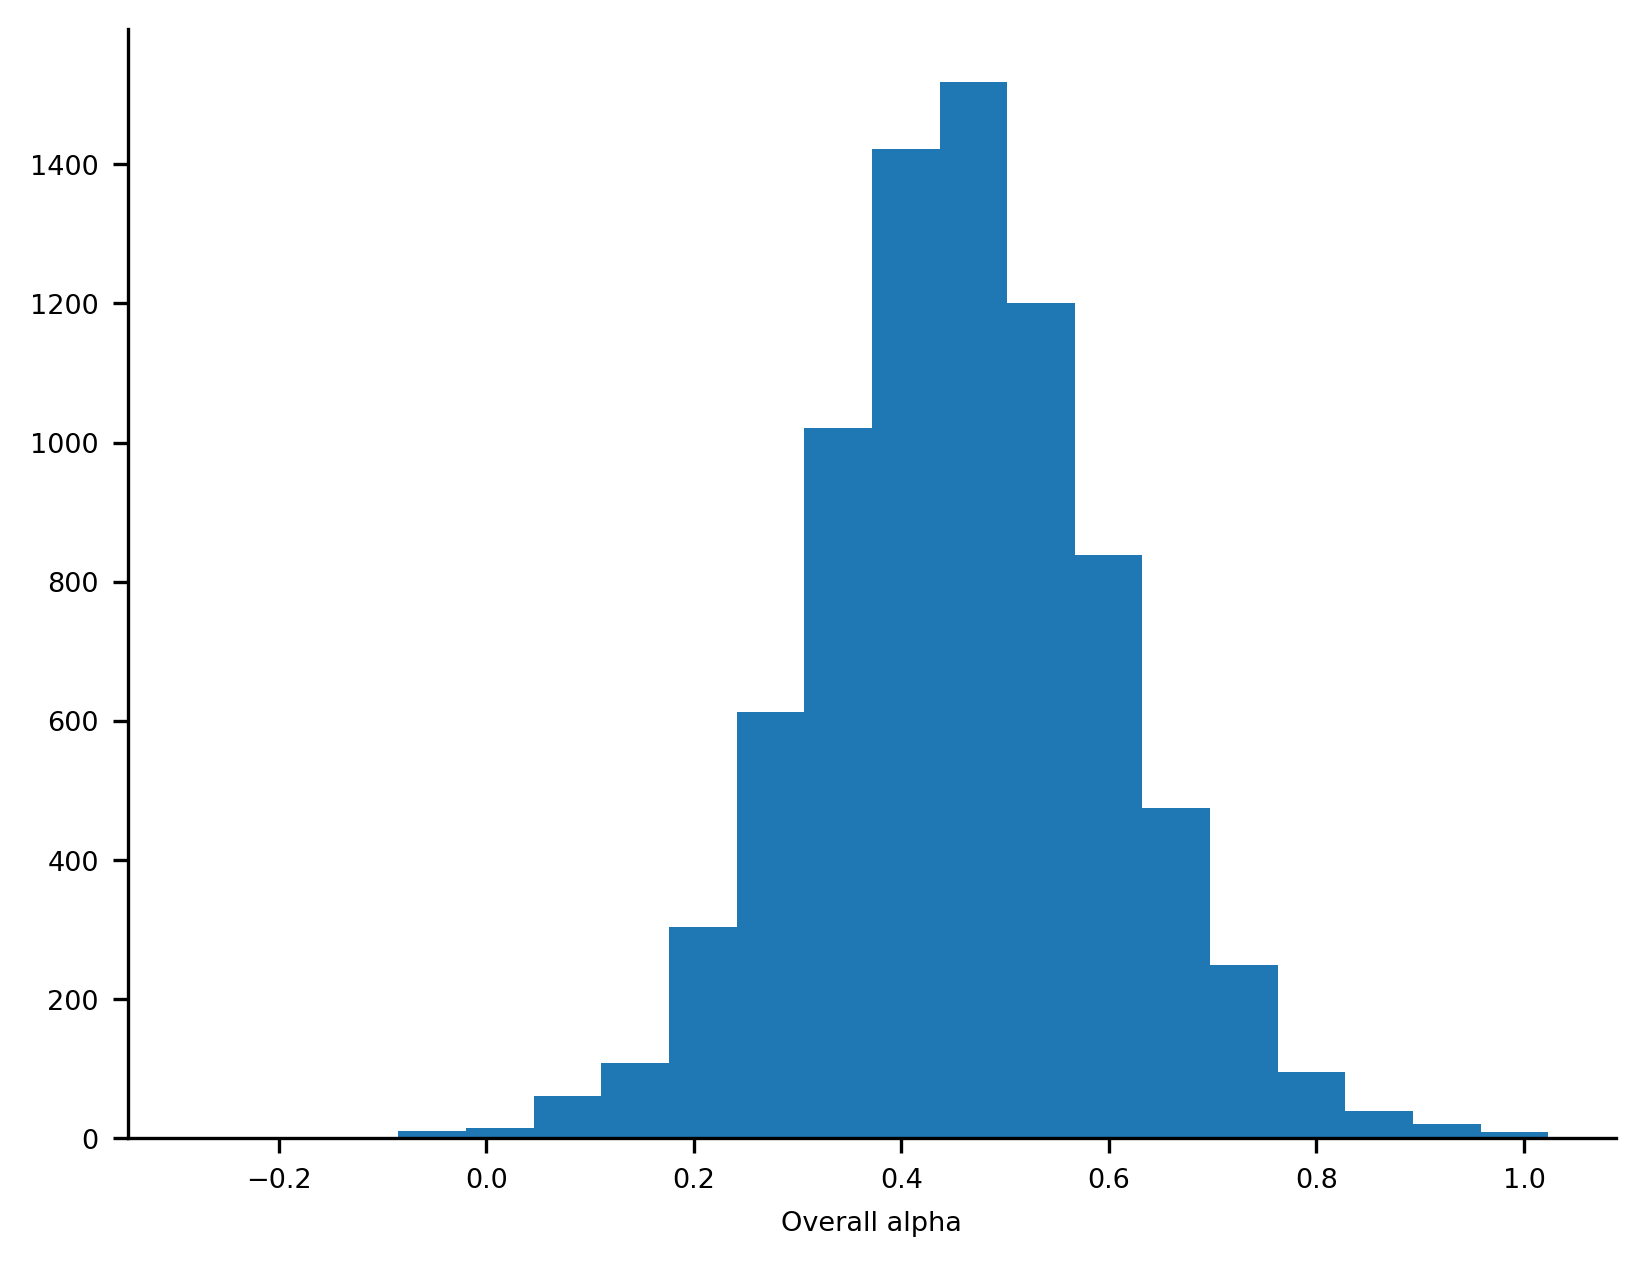

In [35]:
plt.hist(np.array(trace_alpha.posterior['overall_alpha']).flatten(), bins=20)
plt.xlabel("Overall alpha")
plt.show()